In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import HTML

# General
import os

# Drawing
import cartopy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io import shapereader
from matplotlib.cm import get_cmap
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from math import floor
from matplotlib import patheffects
import matplotlib
if os.name == 'nt':
    matplotlib.rc('font', family='Arial')
else:  # might need tweaking, must support black triangle for N arrow
    matplotlib.rc('font', family='DejaVu Sans')

plt.ioff()

In [255]:
DATA_URL = 'https://www.scotland.police.uk/spa-media/s20pfb1o/coronavirus-enforcement-information-to-9-june-2021.xlsx'

from datetime import date
today = date.today()
date_formatted = today.strftime("%d %B %Y")

EXPLANATION = """\
<div class="app-sidebar">
<p><em>Compare the prevalence of different intervention results - geospatially.</em><p>

<p>As a result of the 2020 introduction of the: <a href="https://www.legislation.gov.uk/ssi/2020/103/contents/made">The Health Protection (Coronavirus) (Restrictions) (Scotland) Regulations 2020</a>
and <a href="https://www.legislation.gov.uk/ukpga/2020/7/contents/enacted">Coronavirus Act 2020</a>, 
Police Scotland were mandated to develop a ‘Coronavirus Interventions’ (CVI) recording system.</p>

<p>Police Scotland gather data in reference to the public co-operation levels with this new legislation.
However, it should be noted, the system relies on Police Officers manually updating the system - with the specific co-operation level they "experienced" when they encounter a contravention of the legislation.</p>

<p>As such, the CVI data is indicative only and actual figures may be higher. CVI data is published <a href="https://www.scotland.police.uk/about-us/covid-19-police-scotland-response/enforcement-and-response-data/">weekly</a>
and broken down by date, Police Scotland division, subdivision and the following six categories of CVI:
<ul>
    <li>Total number of people dispersed when informed</li>
    <li>Total number of people dispersed but only when instructed</li>
    <li>Total number of people removed from place or premise</li>
    <li>Total number of people issued a fixed penalty notice</li>
    <li>Total number of people arrested</li>
</ul></p>

<p> The maps show CVI data from 27 March 2020 to 9 June 2021, for each of the above categories, 
in terms of absolute numbers as well as numbers per 100,000 people within a Police Scotland division.</p>

<em>Created by: <a href="https://callumgroeger.com">Callum</a> | """ + date_formatted + """ </em>
<br>
<em>Projection: British National Grid | License: MIT </em>
<br>
<em>Data: Coronavirus Interventions (<a href="https://www.scotland.police.uk/about-us/covid-19-police-scotland-response/enforcement-and-response-data/">Police Scotland</a>), 
2019 Population Estimates (<a href="https://www.nrscotland.gov.uk/statistics-and-data/statistics/statistics-by-theme/population/population-estimates/mid-year-population-estimates/mid-2019">National Records of Scotland</a>),
Police Divisions (<a href="https://spatialdata.gov.scot/geonetwork/srv/eng/catalog.search;jsessionid=61F713CF39B3EE2F440F48E9C31BA806#/metadata/4364af71-167a-4236-b5a0-bd4109913231">Scottish Government</a>)
</em>

</div>
"""

GIF_ADDRESS = 'gif.gif'

In [256]:
HTML("""\
<style>
.app-subtitle {
    font-size: 1.5em;
}

.app-subtitle a {
    color: #106ba3;
}

.app-subtitle a:hover {
    text-decoration: underline;
}

.app-sidebar p {
    margin-bottom: 1em;
    line-height: 1.7;
}

.app-sidebar a {
    color: #106ba3;
}

.app-sidebar a:hover {
    text-decoration: underline;
}
</style>
""")

In [257]:
class App:
    def __init__(self, df):
        self._df = df

        # Get dropdown options, cut out the first five - as this is just Divisions
        available_indicators = list(self._df)
        del available_indicators[0:4]

        # Loading GIF
        with open(GIF_ADDRESS, 'rb') as f:
            img = f.read()
        #   create loading bar widget, ready to display when running long function
        self.loading_bar = widgets.Image(value=img)
        self.loading_bar.layout.object_fit = 'contain'

        self._dropdown1 = self._create_indicator_dropdown(available_indicators, 0)
        self._dropdown2 = self._create_indicator_dropdown([("Absolute", 0), ("Per 100,000", 1)], 0)
        self._plot_container = widgets.Output()

        self._date_slider, date_slider_box = self._create_date_slider(
            df, 'Date'
        )

        self._app_container = widgets.VBox([
            widgets.HBox([
                self._dropdown1,
                self._dropdown2
            ]),
            self._plot_container,
            date_slider_box
        ], layout=widgets.Layout(align_items='center', flex='3 0 auto'))
        self.container = widgets.VBox([
            widgets.HTML(
                (
                    '<h1>Police Scotland Coronavirus Interventions 2020-1</h1>'
                    '<h2 class="app-subtitle"><a href="https://github.com/groegercesg/CovidEnforcementScotland">Link to Github</a></h2>'
                ), 
                layout=widgets.Layout(margin='0 0 5em 0')
            ),
            widgets.HBox([
                self._app_container, 
                widgets.HTML(EXPLANATION, layout=widgets.Layout(margin='0 0 0 2em'))
            ])
        ], layout=widgets.Layout(flex='1 1 auto', margin='0 auto 0 auto', max_width='1024px'))
        self._update_app()


    def _create_date_slider(self, df, column_name):
        from datetime import datetime

        dates = df[column_name]

        options = [(date.strftime(' %d %b %Y '), date) for date in dates]
        index = (0, len(options)-1)

        date_slider_label = widgets.Label('Date range: ')
        date_slider = widgets.SelectionRangeSlider(
            options=options,
            index=index,
            orientation='horizontal',
            layout=widgets.Layout(width='500px')
        )
        """
        date_slider = widgets.IntRangeSlider(
            min=min_date, max=max_date,
            layout=widgets.Layout(width='500px')
        )
        """
        date_slider.observe(self._on_change, names=['value'])
        date_slider_box = widgets.HBox([date_slider_label, date_slider])
        return date_slider, date_slider_box

    def groupByDivision(self, df):
        division_grouped = df.groupby('Division Letter', as_index=False
                                                    ).agg(
                                                    {"Asked / Informed": "sum",
                                                    "Warned / Instructed": "sum",
                                                    "Removed from Place or Premises": "sum",
                                                    "FPN": "sum",
                                                    "Arrested": "sum",
                                                    })

        return division_grouped

    def groupByPopulation(self, df):
        # Process Population Data

        
        # Data from: https://www.nrscotland.gov.uk/statistics-and-data/statistics/statistics-by-theme/population/population-estimates/mid-year-population-estimates/mid-2019

        raw_pop_data = pd.read_csv(os.path.join(os.getcwd(), 'datasets', 'Population', 'mid-year-pop-est-19-data_Table 2.csv'))
        # Keep only the specific columns
        raw_pop_data = raw_pop_data[['Unnamed: 1','Unnamed: 2']]
        # Rename them inplace
        raw_pop_data.rename(columns={'Unnamed: 1': 'Council areas', 'Unnamed: 2': 'Population'}, inplace=True)
        # Drop upper rows that are bad
        raw_pop_data = raw_pop_data.drop(raw_pop_data.index[[0,1,2,3,4]]).reset_index(drop=True)
        # Drop from certain row, minus 1 for the row above position
        raw_pop_data = raw_pop_data[:(raw_pop_data[raw_pop_data['Council areas'] == 'NHS Board areas'].index[0] - 1)]
        # Strip out all the commas in Objects of the Population column
        raw_pop_data["Population"].replace(',','', regex=True, inplace=True)
        # Convert string to int
        raw_pop_data["Population"] = raw_pop_data["Population"].astype(str).astype(int)

        # Group Pop Data

        # We group the council areas into our police divisions
        # First, set our index
        raw_pop_data.set_index('Council areas')
        # Create our division dictionary
        div_dict = {'A': ["Moray", "Aberdeenshire", "Aberdeen City"],
                    'C': ["Stirling", "Clackmannanshire", "Falkirk"],
                    'D': ["Angus", "Dundee City", "Perth and Kinross"],
                    'E': ["City of Edinburgh"],
                    'G': ["East Renfrewshire", "Glasgow City", "East Dunbartonshire"],
                    'J': ["Scottish Borders", "East Lothian", "Midlothian", "West Lothian"],
                    'K': ["Inverclyde", "Renfrewshire"],
                    'L': ["Argyll and Bute", "West Dunbartonshire"],
                    'N': ["Na h-Eileanan Siar", "Orkney Islands", "Highland", "Shetland Islands"],
                    'P': ["Fife"],
                    'Q': ["South Lanarkshire", "North Lanarkshire"],
                    'U': ["South Ayrshire", "East Ayrshire", "North Ayrshire"],
                    'V': ["Dumfries and Galloway"]
                    }

        div_pop = {}

        def divisionPopulation(row):
            incomingRow = row.tolist()

            for div, councils in div_dict.items():
                for council in councils:
                    if (council == incomingRow[0]):
                        if div in div_pop:
                            div_pop[div] += incomingRow[1]
                        else:
                            div_pop[div] = incomingRow[1]

        raw_pop_data.apply(lambda row: divisionPopulation(row), axis=1)

        div_pop_data = pd.DataFrame(div_pop.items(), columns=['Division Letter', 'Population'])

        # Merge Data
        dfMerge = pd.merge(df, div_pop_data, on='Division Letter')

        dfMerge['Asked / Informed per 100k'] = dfMerge.apply (lambda row: row['Asked / Informed']/(row['Population'] / 100000) if row['Population'] > 0 else 0, axis=1)
        dfMerge['Warned / Instructed per 100k'] = dfMerge.apply (lambda row: row['Warned / Instructed']/(row['Population'] / 100000) if row['Population'] > 0 else 0, axis=1)
        dfMerge['Removed from Place or Premises per 100k'] = dfMerge.apply (lambda row: row['Removed from Place or Premises']/(row['Population'] / 100000) if row['Population'] > 0 else 0, axis=1)
        dfMerge['FPN per 100k'] = dfMerge.apply (lambda row: row['FPN']/(row['Population'] / 100000) if row['Population'] > 0 else 0, axis=1)
        dfMerge['Arrested per 100k'] = dfMerge.apply (lambda row: row['Arrested']/(row['Population'] / 100000) if row['Population'] > 0 else 0, axis=1)
        
        return dfMerge
        
    # The class method, we use this to gather the data then pre-process it
    @classmethod
    def from_url(cls, url):
        raw_data = pd.read_excel(url, sheet_name=1)
        raw_data.drop(['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17'], axis=1, inplace=True)

        # Taking account of NaNs
        # Explanation:
        # The xlsx to pandas dataframe conversion seems to have taken "NA" for a division "N" and an Area Command "Inverness"
        # and interpret that "NA" as actually: "NaN". Which is very annoying. So the below overwrites the SD letter of area commands
        # that are inverness and turns them back to "NA"
        raw_data.loc[raw_data["Area Commands"] == "Inverness", "SD Letter"] = raw_data["SD Letter"].fillna("NA")

        if (raw_data.isnull().sum().sum() != 0):
            raise ValueError("We have NaNs in our dataframe")

        return cls(raw_data)
        
    def _create_indicator_dropdown(self, indicators, initial_index):
        # Handling for the two different types of Dropdown options storage
        if isinstance(indicators[initial_index], tuple):
            valuePos = initial_index
        elif isinstance(indicators[initial_index], str):
            valuePos = indicators[initial_index]
        else:
            raise ValueError("Unknown dropdown input type")
        
        dropdown = widgets.Dropdown(options=indicators, value=valuePos)
        dropdown.observe(self._on_change, names=['value'])
        return dropdown
    

    def utm_from_lon(self, lon):
        """
        utm_from_lon - UTM zone for a longitude

        Not right for some polar regions (Norway, Svalbard, Antartica)

        :param float lon: longitude
        :return: UTM zone number
        :rtype: int
        """
        return floor( ( lon + 180 ) / 6) + 1

    def scale_bar(self, ax, proj, length, location=(0.5, 0.05), linewidth=3,
                units='km', m_per_unit=1000):
        """
        http://stackoverflow.com/a/35705477/1072212
        ax is the axes to draw the scalebar on.
        proj is the projection the axes are in
        location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
        length is the length of the scalebar in km.
        linewidth is the thickness of the scalebar.
        units is the name of the unit
        m_per_unit is the number of meters in a unit
        """
        # find lat/lon center to find best UTM zone
        x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
        # Projection in metres
        utm = ccrs.UTM(self.utm_from_lon((x0+x1)/2))
        # Get the extent of the plotted area in coordinates in metres
        x0, x1, y0, y1 = ax.get_extent(utm)
        # Turn the specified scalebar location into coordinates in metres
        sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
        # Generate the x coordinate for the ends of the scalebar
        bar_xs = [sbcx - length * m_per_unit/2, sbcx + length * m_per_unit/2]
        # buffer for scalebar
        buffer = [patheffects.withStroke(linewidth=5, foreground="w")]
        # Plot the scalebar with buffer
        ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
            linewidth=linewidth, path_effects=buffer)
        # buffer for text
        buffer = [patheffects.withStroke(linewidth=3, foreground="w")]
        # Plot the scalebar label
        t0 = ax.text(sbcx, sbcy, str(length) + ' ' + units, transform=utm,
            horizontalalignment='center', verticalalignment='bottom',
            path_effects=buffer, zorder=2)
        left = x0+(x1-x0)*0.05
        # Plot the N arrow
        t1 = ax.text(left, sbcy, u'\u25B2\nN', transform=utm,
            horizontalalignment='center', verticalalignment='bottom',
            path_effects=buffer, zorder=2)
        # Plot the scalebar without buffer, in case covered by text buffer
        ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
            linewidth=linewidth, zorder=3)
    
    def _create_plot(self, indicator, scaling):
        fig = plt.figure(figsize=(6,8), dpi=100)
        projectionPARAM = ccrs.TransverseMercator(central_longitude=-2.0, central_latitude=49.0, false_easting=400000.0, false_northing=-100000.0, scale_factor=0.9996012717, approx=False)
        ax = fig.add_subplot(1, 1, 1, projection=projectionPARAM)
        ax.set_extent([-8, 0, 54.5, 61]) # Ideal coordinate map range for plotting Scotland

        # Process the input from the second dropdown
        if scaling == 0:
            indicator = indicator
        elif scaling == 1:
            indicator = indicator + " per 100k"
        else:
            raise ValueError("Bizarre dropdown option achieved, investigation needed!")

        police_dict = (self._df[['Division Letter', indicator]].set_index('Division Letter').T.to_dict('records'))[0]

        # Downloaded from: https://spatialdata.gov.scot/geonetwork/srv/eng/catalog.search;jsessionid=61F713CF39B3EE2F440F48E9C31BA806#/metadata/4364af71-167a-4236-b5a0-bd4109913231
        area_file = os.path.join(os.getcwd(), 'datasets', 'ScottishPoliceDivisions', 'SG_ScottishPoliceDivisions_2019.shp')
        police_divisions = shapereader.Reader(area_file)

        norm = colors.Normalize(vmin=0., vmax=max(police_dict.values()))
        cmap = get_cmap('PuBu')

        for record in police_divisions.records():
            code = record.attributes['AdminCode']
            police_entry = police_dict.get(code, -1)
            if police_entry == -1:
                police_color = "Silver"
            else:
                police_color = cmap(police_entry/max(police_dict.values()))
            ax.add_geometries(
                    [record.geometry],
                    #facecolor=numpy.random.rand(3,),
                    facecolor=police_color,
                    linewidth=0,
                    crs=projectionPARAM,
            )

        # following https://matplotlib.org/2.0.2/mpl_toolkits/axes_grid/users/overview.html#colorbar-whose-height-or-width-in-sync-with-the-master-axes
        # we need to set axes_class=plt.Axes, else it attempts to create
        # a GeoAxes as colorbar

        divider = make_axes_locatable(ax)
        ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)

        fig.add_axes(ax_cb)

        sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        cb = plt.colorbar(sm, cax=ax_cb)
        cb.set_label(indicator)

        #self.scale_bar(ax, projectionPARAM, 100, location=(0.85, 0.05))  # 100 km scale bar

        plt.plot()
        
    def _on_change(self, _):
        self._update_app()

    def _process_data(self):
        self._df = self.groupByDivision(self._df)
        self._df = self.groupByPopulation(self._df)
        
    def _update_app(self):
        # Pull in widget attributes for passing to plot function
        indicator = self._dropdown1.value
        scaling = self._dropdown2.value
        date_range = self._date_slider.value
        print(date_range)

        # Process data
        self._process_data()

        self._plot_container.clear_output()
            # wait=True
        with self._plot_container:
            #self.loading_bar.layout.visibility = 'visible'
            self.loading_bar.layout.display = 'block'   
            display(self.loading_bar)
            self._create_plot(indicator, scaling)
            plt.show()
            #self.loading_bar.layout.visibility = 'hidden'
            self.loading_bar.layout.display = 'none'


(Timestamp('2020-03-27 00:00:00'), Timestamp('2021-06-07 00:00:00'))


Image(value=b'GIF89a\xc2\x01\x96\x00\xc4\x00\x00\xff\xff\xff\xfb\xfb\xfb\xf7\xf7\xf7\xf3\xf3\xf3\xef\xef\xef\x…

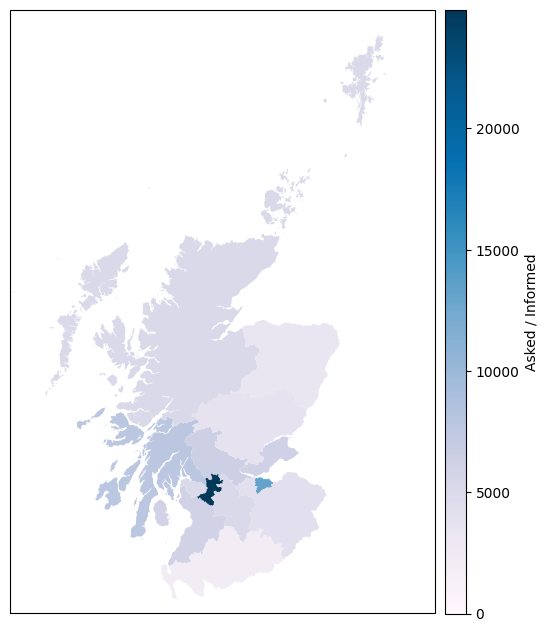

In [258]:
app = App.from_url(DATA_URL)

app.container